In [1]:
import time

import numpy as np
import pyro
import pyro.contrib.examples.multi_mnist as multi_mnist
from pyro.infer import (
    SVI,
    RenyiELBO,
    TraceGraph_ELBO,
    TraceEnum_ELBO,
    ReweightedWakeSleep,
)
from pyro.optim import Adam
import pandas as pd

import torch
from pyro_air import AIR, make_prior, get_per_param_lr, count_accuracy, visualize_model

In [2]:
#####################
# Benchmark Configs
#####################
seed = 123456
use_cuda = torch.cuda.is_available()
batch_size = 1
num_epoches = 20

z_pres_prior = 0.01
learning_rate = 1e-4
baseline_lr = 1e-1
elbo = ReweightedWakeSleep(num_particles=10)
# explicitly list out all configurable options
air_model_args = dict(
    num_steps=3,
    x_size=50,
    window_size=28,
    z_what_size=50,
    rnn_hidden_size=256,
    encoder_net=[200],
    decoder_net=[200],
    predict_net=[200],
    embed_net=None,
    bl_predict_net=[200],
    non_linearity="ReLU",
    decoder_output_bias=-2,
    decoder_output_use_sigmoid=True,
    use_masking=True,
    use_baselines=False,
    baseline_scalar=None,
    scale_prior_mean=3.0,
    scale_prior_sd=0.2,
    pos_prior_mean=0.0,
    pos_prior_sd=1.0,
    likelihood_sd=0.3,
    use_cuda=use_cuda,
)

In [3]:
#####################
# Initial Setup
#####################
device = torch.device("cuda" if use_cuda else "cpu")
z_pres_prior_fn = lambda t: [0.003, 2.7e-08, 2.43e-13][t]


X, Y = multi_mnist.load("data/air/.data")
X = (torch.from_numpy(X).float() / 255.0).to(device)
visualize_examples = X[5:10]
# Using float to allow comparison with values sampled from
# Bernoulli.
true_counts = torch.tensor([len(objs) for objs in Y], dtype=torch.float)

/Users/xiaoyan/miniconda3/envs/genjax/lib/python3.11/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/xiaoyan/miniconda3/envs/genjax/lib/python3.11/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/xiaoyan/miniconda3/envs/genjax/lib/python3.11/site-packages/torch/nn/functional.py:4399: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::affine_grid_generator. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /

Epoch=0, current_epoch_step_time=1466.47, loss=-252.00
accuracy=0.6495500206947327, counts=tensor([[19574,   374,     0,     0],
        [  612, 19398,     0,    10],
        [   23, 19911,     1,    97]])


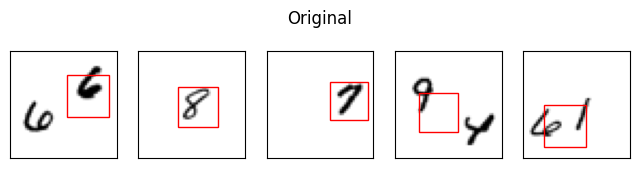

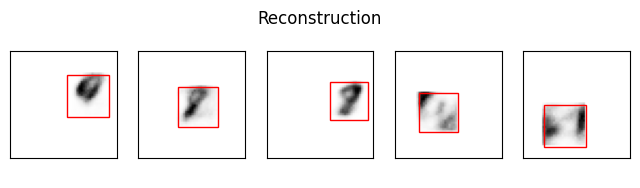

KeyboardInterrupt: 

In [4]:
if seed is not None:
    pyro.set_rng_seed(seed)
pyro.distributions.enable_validation(False)
pyro.clear_param_store()  # just in case

air = AIR(**air_model_args)
adam = Adam(get_per_param_lr(learning_rate, baseline_lr))
svi = SVI(air.model, air.guide, adam, loss=elbo)

all_loss = []
all_accuracy = []
time_per_epoch = []

for i in range(num_epoches):
    start_time = time.perf_counter()
    # technically this might step over slightly more than 1 epoch...
    losses = []
    for j in range(int(np.ceil(X.size(0) / batch_size))):
        losses.append(
            svi.step(X, batch_size=batch_size, z_pres_prior_p=z_pres_prior_fn)
        )
    end_time = time.perf_counter()

    accuracy, counts, error_z, error_ix = count_accuracy(X, true_counts, air, 1000)

    all_loss.append(np.mean(losses) / X.size(0))
    all_accuracy.append(accuracy)
    time_per_epoch.append(end_time - start_time)

    print(
        f"Epoch={i}, current_epoch_step_time={time_per_epoch[-1]:.2f}, loss={all_loss[-1]:.2f}"
    )
    if i % 5 == 0:
        print(f"accuracy={accuracy}, counts={counts}")
        visualize_model(visualize_examples, air)

In [ ]:
wall_clock_times = np.cumsum(time_per_epoch)
arr = np.array([all_loss, all_accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["ELBO Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv("./training_runs/pyro_rws_bsize1_mccoy_prior.csv", index=False)